In [19]:
# visualize_axial_attention.py
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from stable_baselines3 import PPO
from utils import FEATURE_NAMES

# ---- Config you fill in ----
MODEL_PATH = r"C:\initial_model\historic_3\attention_PPO_63_100_000_20_20_vms_arch_64\attention\MlpPolicy\attention_MlpPolicy_mlp_200_000_64"   # your saved model
L = 8                                  # memory window used in your wrapper
F = 7                                   # number of metrics/features
MAX_EPISODE_STEPS = 500                 # for distance-based PE (ok if larger than episode)

# observations_7: numpy array of shape (T, 7) collected from your test_model (or similar)
# e.g., load from .npy or .npz
observations_7 = np.load(r'C:\initial_model\historic_3\attention_PPO_63_100_000_20_20_vms_arch_64\attention\MlpPolicy\observations_attention_MlpPolicy_1.npy', allow_pickle=True)  # shape (T, 7), values in [0,1]
def preprocess_transformers_observation(X):
    # returns (T, D) float32 with only 'h'
    if getattr(X, 'dtype', None) == object:                       # object array of dicts
        H = np.stack([np.asarray(d['h']) for d in X])
        return (H[:, 0, :].astype(np.float32) if H.ndim == 3 else H.astype(np.float32))
    X = np.asarray(X)
    if X.ndim == 5: X = X.squeeze((1, 2))[:, -1, :]              # (T,1,1,4,D) -> last of 4 -> (T,D)
    if X.ndim == 3 and X.shape[1] == 1: X = X[:, 0, :]  
    return X
observations_7=preprocess_transformers_observation(observations_7)
print(observations_7.shape)
#observations_7 = observations_7.squeeze(axis=1)
# ---- Helpers to rebuild Dict obs for the policy ----
def build_obs_dict_seq(seq_7, t, L, max_steps):
    """
    Build a single-sample Dict observation at time t from a flat sequence of (7,) obs.
    Returns a dict with N=1 batch: keys 'h', 'memories', 'mask', 'memory_indices', 'current_index'.
    """
    # current obs (7,)
    h = seq_7[t].astype(np.float32)

    # memory = last L previous h's (not including current), right-aligned
    mem = np.zeros((L, F), dtype=np.float32)
    mask = np.zeros((L,), dtype=np.int8)
    idx  = np.zeros((L,), dtype=np.int64)

    # valid past indices
    start = max(0, t - L)
    hist = seq_7[start:t]                        # up to (<= L, 7)
    n = hist.shape[0]
    if n > 0:
        mem[-n:] = hist.astype(np.float32)
        mask[-n:] = 1
        idx[-n:] = np.arange(start, t, dtype=np.int64)

    obs = {
        "h": h[None, :],                         # (1, 7)
        "memories": mem[None, :, :],             # (1, L, 7)  (raw memories; extractor will embed)
        "mask": mask[None, :],                   # (1, L)
        "memory_indices": idx[None, :],          # (1, L) absolute times
        "current_index": np.array([t], dtype=np.int64),   # (1,)
    }
    return obs

def get_attn_from_obs(model, obs_dict_np):
    """
    Runs the extractor forward to populate attention tensors.
    Returns (time_attn, feat_attn):
      - time_attn: (heads, L)  (averaged over query dim)
      - feat_attn: (heads, F, F)
    """
    policy = model.policy
    policy.eval()

    # Convert to torch tensors on correct device
    obs_t, _ = policy.obs_to_tensor(obs_dict_np)

    # Extract features (populates last attention)
    _ = policy.extract_features(obs_t)

    # Pull attention maps
    # time: (N, H, 1, L), feature: (N, H, F, F)
    t_attn = policy.features_extractor.last_time_attention
    f_attn = policy.features_extractor.last_feature_attention
    if t_attn is None or f_attn is None:
        raise RuntimeError("Attention maps not found. Ensure you are using the Axial extractor and called extract_features once.")

    # Remove batch and query dims
    t_attn = t_attn[0].squeeze(1).detach().cpu().numpy()   # (H, L)
    f_attn = f_attn[0].detach().cpu().numpy()              # (H, F, F)
    return t_attn, f_attn

# ---- Load model ----
device = "cuda" if torch.cuda.is_available() else "cpu"
model = PPO.load(MODEL_PATH, device=device)

# ---- Collect attentions over the sequence ----
T = observations_7.shape[0]
all_time = []  # list of (H, L)
all_feat = []  # list of (H, F, F)

for t in range(T):
    obs_dict = build_obs_dict_seq(observations_7, t, L=L, max_steps=MAX_EPISODE_STEPS)
    t_attn, f_attn = get_attn_from_obs(model, obs_dict)
    all_time.append(t_attn)
    all_feat.append(f_attn)

# Stack and average across time and heads
all_time = np.stack(all_time, axis=0)            # (T, H, L)
all_feat = np.stack(all_feat, axis=0)            # (T, H, F, F)

mean_time = all_time.mean(axis=(0, 1))           # (L,)
mean_feat = all_feat.mean(axis=(0, 1))           # (F, F)

# Normalize for display (optional, keeps ratios)
mean_time = mean_time / (mean_time.sum() + 1e-8)
mean_feat = mean_feat / (mean_feat.sum() + 1e-8)

# ---- Build "attention x attention" joint map ----
# A simple, interpretable choice:
#   - reduce feature attention to per-feature centrality (column mean)
#   - outer product with time attention -> (L, F)
feat_centrality = mean_feat.mean(axis=0)         # (F,) importance of each feature as a "recipient"
feat_centrality = feat_centrality / (feat_centrality.sum() + 1e-8)
joint_time_feat = np.outer(mean_time, feat_centrality)  # (L, F)

# If you prefer a richer joint tensor (L, F, F), use:
# joint_tensor = all_time.mean(axis=1)[:, :, None, None] * all_feat.mean(axis=1)  # (T, 1, L, 1, 1)*(T,H,F,F)->(T,H,L,F,F)
# joint_tensor = joint_tensor.mean(axis=(0,1))  # (L, F, F)
# ...and plot slices or norms over F.

# ---- Visualize ----
plt.figure(figsize=(12, 9))

# 1) Mean time attention
plt.subplot(2, 2, 1)
plt.title("Średnie wagi Attention dla kroków czasowych (L)")
plt.plot(mean_time)
plt.xlabel("Indeks w pamięci (0=najstarszy → L-1=najnowszy)")
plt.ylabel("waga")

# 2) Mean feature↔feature attention
plt.subplot(2, 2, 2)
plt.title("Średnia wartość wag Attention dla cech  (F×F)")
plt.imshow(mean_feat, aspect="auto")
plt.colorbar()
plt.xlabel("Key/Value dla cechy")
plt.ylabel("Query dla cechy")

# 3) Attention × Attention (L×F)
plt.subplot(2, 1, 2)
plt.title("Attention × Attention (Czas × Cecha)")
plt.imshow(joint_time_feat, aspect="auto")
plt.colorbar()
plt.xlabel("Cecha")
plt.ylabel("Indeks w pamięci (0=najstarszy → L-1=najnowszy)")

plt.tight_layout()
plt.show()


(2410, 7)


c:\Users\ultramarine\.conda\envs\trainloop_py37\lib\site-packages\ipykernel_launcher.py:156: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


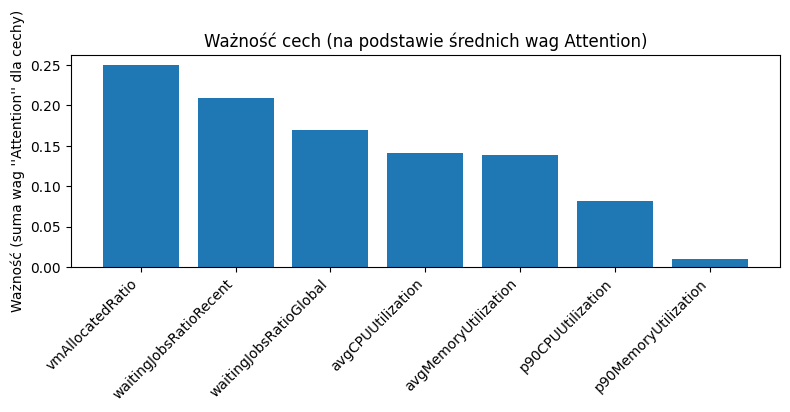

In [12]:
imp = mean_feat.sum(axis=0)                    # incoming mass per feature (column-sum)
order = np.argsort(imp)[::-1]                 # sort high → low

plt.figure(figsize=(8, 4))
plt.title("Ważność cech (na podstawie średnich wag Attention)")
plt.bar(np.arange(len(imp)), imp[order])
plt.xticks(np.arange(len(imp)), [FEATURE_NAMES[i] for i in order], rotation=45, ha='right')       # show feature indices in sorted order
plt.ylabel("Ważność (suma wag ''Attention'' dla cechy)")
plt.tight_layout()
plt.show()

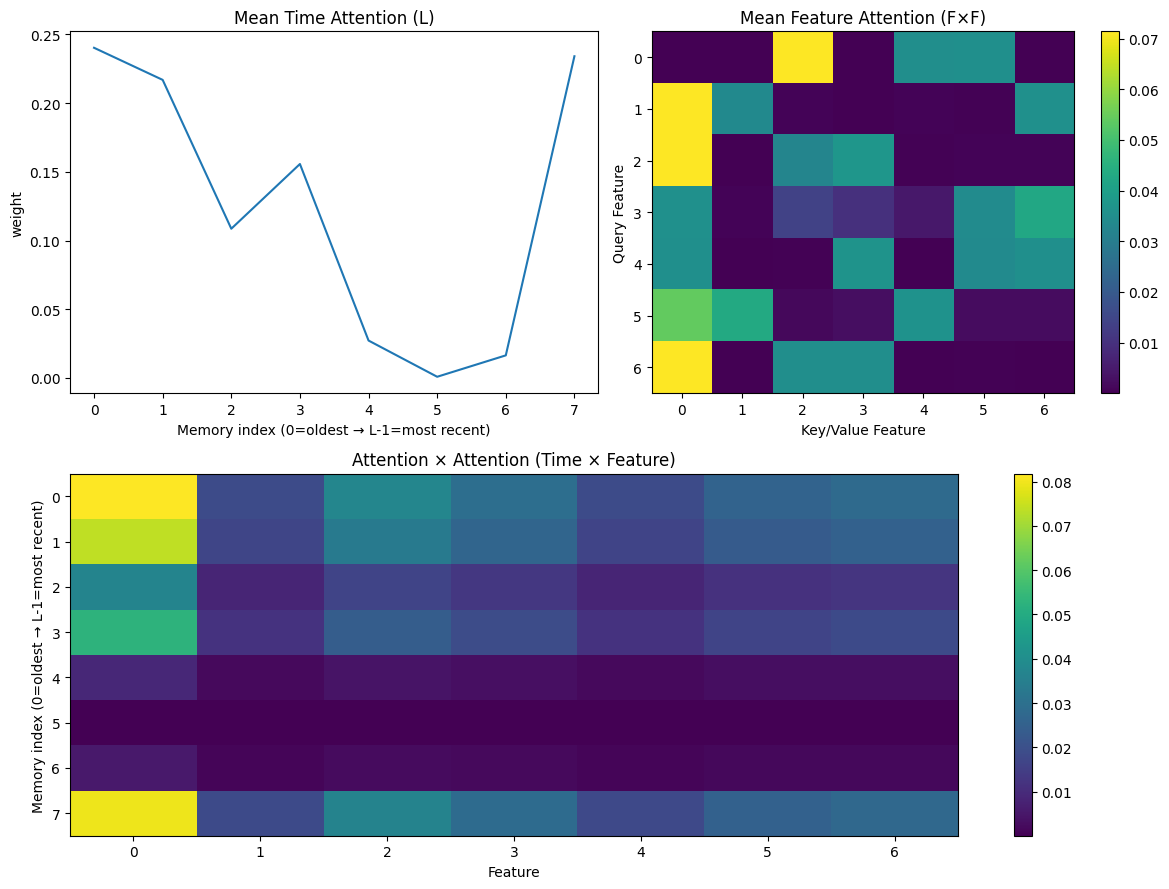

In [9]:
# visualize_axial_attention.py
import numpy as np
import torch
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

# ---- Config you fill in ----
MODEL_PATH = r"C:\initial_model\historic\attention\MlpPolicy\attention_MlpPolicy"   # your saved model
L = 8                                  # memory window used in your wrapper
F = 7                                   # number of metrics/features
MAX_EPISODE_STEPS = 500                 # for distance-based PE (ok if larger than episode)

# observations_7: numpy array of shape (T, 7) collected from your test_model (or similar)
# e.g., load from .npy or .npz
observations_7 = np.load(r'C:\initial_model\historic\attention\MlpPolicy\observations.npy')  # shape (T, 7), values in [0,1]
observations_7 = observations_7.squeeze(axis=1)
# ---- Helpers to rebuild Dict obs for the policy ----
def build_obs_dict_seq(seq_7, t, L, max_steps):
    """
    Build a single-sample Dict observation at time t from a flat sequence of (7,) obs.
    Returns a dict with N=1 batch: keys 'h', 'memories', 'mask', 'memory_indices', 'current_index'.
    """
    # current obs (7,)
    h = seq_7[t].astype(np.float32)

    # memory = last L previous h's (not including current), right-aligned
    mem = np.zeros((L, F), dtype=np.float32)
    mask = np.zeros((L,), dtype=np.int8)
    idx  = np.zeros((L,), dtype=np.int64)

    # valid past indices
    start = max(0, t - L)
    hist = seq_7[start:t]                        # up to (<= L, 7)
    n = hist.shape[0]
    if n > 0:
        mem[-n:] = hist.astype(np.float32)
        mask[-n:] = 1
        idx[-n:] = np.arange(start, t, dtype=np.int64)

    obs = {
        "h": h[None, :],                         # (1, 7)
        "memories": mem[None, :, :],             # (1, L, 7)  (raw memories; extractor will embed)
        "mask": mask[None, :],                   # (1, L)
        "memory_indices": idx[None, :],          # (1, L) absolute times
        "current_index": np.array([t], dtype=np.int64),   # (1,)
    }
    return obs

def get_attn_from_obs(model, obs_dict_np):
    """
    Runs the extractor forward to populate attention tensors.
    Returns (time_attn, feat_attn):
      - time_attn: (heads, L)  (averaged over query dim)
      - feat_attn: (heads, F, F)
    """
    policy = model.policy
    policy.eval()

    # Convert to torch tensors on correct device
    obs_t, _ = policy.obs_to_tensor(obs_dict_np)

    # Extract features (populates last attention)
    _ = policy.extract_features(obs_t)

    # Pull attention maps
    # time: (N, H, 1, L), feature: (N, H, F, F)
    t_attn = policy.features_extractor.last_time_attention
    f_attn = policy.features_extractor.last_feature_attention
    if t_attn is None or f_attn is None:
        raise RuntimeError("Attention maps not found. Ensure you are using the Axial extractor and called extract_features once.")

    # Remove batch and query dims
    t_attn = t_attn[0].squeeze(1).detach().cpu().numpy()   # (H, L)
    f_attn = f_attn[0].detach().cpu().numpy()              # (H, F, F)
    return t_attn, f_attn

# ---- Load model ----
device = "cuda" if torch.cuda.is_available() else "cpu"
model = PPO.load(MODEL_PATH, device=device)

# ---- Collect attentions over the sequence ----
T = observations_7.shape[0]
all_time = []  # list of (H, L)
all_feat = []  # list of (H, F, F)

for t in range(T):
    obs_dict = build_obs_dict_seq(observations_7, t, L=L, max_steps=MAX_EPISODE_STEPS)
    t_attn, f_attn = get_attn_from_obs(model, obs_dict)
    all_time.append(t_attn)
    all_feat.append(f_attn)

# Stack and average across time and heads
all_time = np.stack(all_time, axis=0)            # (T, H, L)
all_feat = np.stack(all_feat, axis=0)            # (T, H, F, F)

mean_time = all_time.mean(axis=(0, 1))           # (L,)
mean_feat = all_feat.mean(axis=(0, 1))           # (F, F)

# Normalize for display (optional, keeps ratios)
mean_time = mean_time / (mean_time.sum() + 1e-8)
mean_feat = mean_feat / (mean_feat.sum() + 1e-8)

# ---- Build "attention x attention" joint map ----
# A simple, interpretable choice:
#   - reduce feature attention to per-feature centrality (column mean)
#   - outer product with time attention -> (L, F)
feat_centrality = mean_feat.mean(axis=0)         # (F,) importance of each feature as a "recipient"
feat_centrality = feat_centrality / (feat_centrality.sum() + 1e-8)
joint_time_feat = np.outer(mean_time, feat_centrality)  # (L, F)

# If you prefer a richer joint tensor (L, F, F), use:
# joint_tensor = all_time.mean(axis=1)[:, :, None, None] * all_feat.mean(axis=1)  # (T, 1, L, 1, 1)*(T,H,F,F)->(T,H,L,F,F)
# joint_tensor = joint_tensor.mean(axis=(0,1))  # (L, F, F)
# ...and plot slices or norms over F.

# ---- Visualize ----
plt.figure(figsize=(12, 9))

# 1) Mean time attention
plt.subplot(2, 2, 1)
plt.title("Mean Time Attention (L)")
plt.plot(mean_time)
plt.xlabel("Memory index (0=oldest → L-1=most recent)")
plt.ylabel("weight")

# 2) Mean feature↔feature attention
plt.subplot(2, 2, 2)
plt.title("Mean Feature Attention (F×F)")
plt.imshow(mean_feat, aspect="auto")
plt.colorbar()
plt.xlabel("Key/Value Feature")
plt.ylabel("Query Feature")

# 3) Attention × Attention (L×F)
plt.subplot(2, 1, 2)
plt.title("Attention × Attention (Time × Feature)")
plt.imshow(joint_time_feat, aspect="auto")
plt.colorbar()
plt.xlabel("Feature")
plt.ylabel("Memory index (0=oldest → L-1=most recent)")

plt.tight_layout()
plt.show()

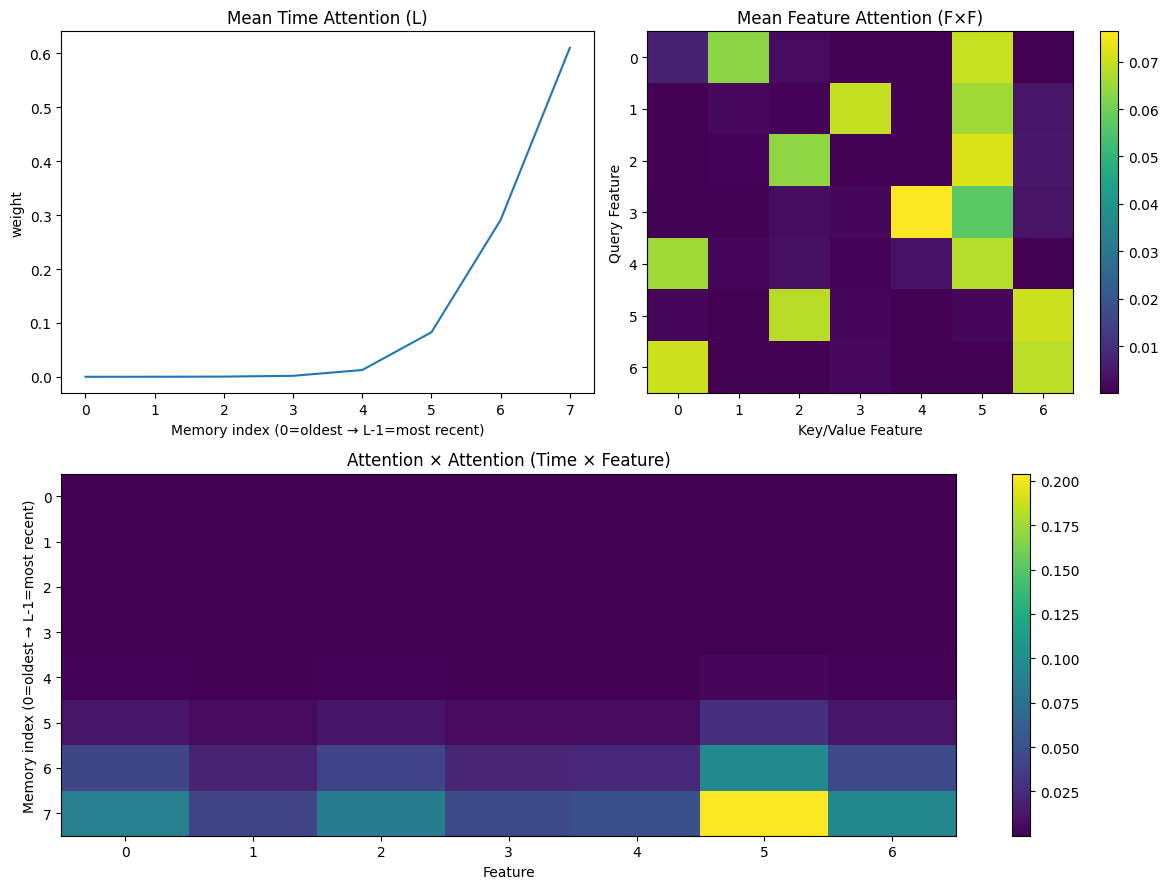

In [ ]:
# visualize_axial_attention.py
import numpy as np
import torch
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

# ---- Config you fill in ----
MODEL_PATH = r"C:\initial_model\attention\MlpPolicy\attention_MlpPolicy"   # your saved model #przebieg PPO_65
L = 8                                  # memory window used in your wrapper
F = 7                                   # number of metrics/features
MAX_EPISODE_STEPS = 500                 # for distance-based PE (ok if larger than episode)

# observations_7: numpy array of shape (T, 7) collected from your test_model (or similar)
# e.g., load from .npy or .npz
observations_7 = np.load(r'C:\initial_model\attention\MlpPolicy\observations.npy')  # shape (T, 7), values in [0,1]
observations_7 = observations_7.squeeze(axis=1)
# ---- Helpers to rebuild Dict obs for the policy ----
def build_obs_dict_seq(seq_7, t, L, max_steps):
    """
    Build a single-sample Dict observation at time t from a flat sequence of (7,) obs.
    Returns a dict with N=1 batch: keys 'h', 'memories', 'mask', 'memory_indices', 'current_index'.
    """
    # current obs (7,)
    h = seq_7[t].astype(np.float32)

    # memory = last L previous h's (not including current), right-aligned
    mem = np.zeros((L, F), dtype=np.float32)
    mask = np.zeros((L,), dtype=np.int8)
    idx  = np.zeros((L,), dtype=np.int64)

    # valid past indices
    start = max(0, t - L)
    hist = seq_7[start:t]                        # up to (<= L, 7)
    n = hist.shape[0]
    if n > 0:
        mem[-n:] = hist.astype(np.float32)
        mask[-n:] = 1
        idx[-n:] = np.arange(start, t, dtype=np.int64)

    obs = {
        "h": h[None, :],                         # (1, 7)
        "memories": mem[None, :, :],             # (1, L, 7)  (raw memories; extractor will embed)
        "mask": mask[None, :],                   # (1, L)
        "memory_indices": idx[None, :],          # (1, L) absolute times
        "current_index": np.array([t], dtype=np.int64),   # (1,)
    }
    return obs

def get_attn_from_obs(model, obs_dict_np):
    """
    Runs the extractor forward to populate attention tensors.
    Returns (time_attn, feat_attn):
      - time_attn: (heads, L)  (averaged over query dim)
      - feat_attn: (heads, F, F)
    """
    policy = model.policy
    policy.eval()

    # Convert to torch tensors on correct device
    obs_t, _ = policy.obs_to_tensor(obs_dict_np)

    # Extract features (populates last attention)
    _ = policy.extract_features(obs_t)

    # Pull attention maps
    # time: (N, H, 1, L), feature: (N, H, F, F)
    t_attn = policy.features_extractor.last_time_attention
    f_attn = policy.features_extractor.last_feature_attention
    if t_attn is None or f_attn is None:
        raise RuntimeError("Attention maps not found. Ensure you are using the Axial extractor and called extract_features once.")

    # Remove batch and query dims
    t_attn = t_attn[0].squeeze(1).detach().cpu().numpy()   # (H, L)
    f_attn = f_attn[0].detach().cpu().numpy()              # (H, F, F)
    return t_attn, f_attn

# ---- Load model ----
device = "cuda" if torch.cuda.is_available() else "cpu"
model = PPO.load(MODEL_PATH, device=device)

# ---- Collect attentions over the sequence ----
T = observations_7.shape[0]
all_time = []  # list of (H, L)
all_feat = []  # list of (H, F, F)

for t in range(T):
    obs_dict = build_obs_dict_seq(observations_7, t, L=L, max_steps=MAX_EPISODE_STEPS)
    t_attn, f_attn = get_attn_from_obs(model, obs_dict)
    all_time.append(t_attn)
    all_feat.append(f_attn)

# Stack and average across time and heads
all_time = np.stack(all_time, axis=0)            # (T, H, L)
all_feat = np.stack(all_feat, axis=0)            # (T, H, F, F)

mean_time = all_time.mean(axis=(0, 1))           # (L,)
mean_feat = all_feat.mean(axis=(0, 1))           # (F, F)

# Normalize for display (optional, keeps ratios)
mean_time = mean_time / (mean_time.sum() + 1e-8)
mean_feat = mean_feat / (mean_feat.sum() + 1e-8)

# ---- Build "attention x attention" joint map ----
# A simple, interpretable choice:
#   - reduce feature attention to per-feature centrality (column mean)
#   - outer product with time attention -> (L, F)
feat_centrality = mean_feat.mean(axis=0)         # (F,) importance of each feature as a "recipient"
feat_centrality = feat_centrality / (feat_centrality.sum() + 1e-8)
joint_time_feat = np.outer(mean_time, feat_centrality)  # (L, F)

# If you prefer a richer joint tensor (L, F, F), use:
# joint_tensor = all_time.mean(axis=1)[:, :, None, None] * all_feat.mean(axis=1)  # (T, 1, L, 1, 1)*(T,H,F,F)->(T,H,L,F,F)
# joint_tensor = joint_tensor.mean(axis=(0,1))  # (L, F, F)
# ...and plot slices or norms over F.

# ---- Visualize ----
plt.figure(figsize=(12, 9))

# 1) Mean time attention
plt.subplot(2, 2, 1)
plt.title("Mean Time Attention (L)")
plt.plot(mean_time)
plt.xlabel("Memory index (0=oldest → L-1=most recent)")
plt.ylabel("weight")

# 2) Mean feature↔feature attention
plt.subplot(2, 2, 2)
plt.title("Mean Feature Attention (F×F)")
plt.imshow(mean_feat, aspect="auto")
plt.colorbar()
plt.xlabel("Key/Value Feature")
plt.ylabel("Query Feature")

# 3) Attention × Attention (L×F)
plt.subplot(2, 1, 2)
plt.title("Attention × Attention (Time × Feature)")
plt.imshow(joint_time_feat, aspect="auto")
plt.colorbar()
plt.xlabel("Feature")
plt.ylabel("Memory index (0=oldest → L-1=most recent)")

plt.tight_layout()
plt.show()


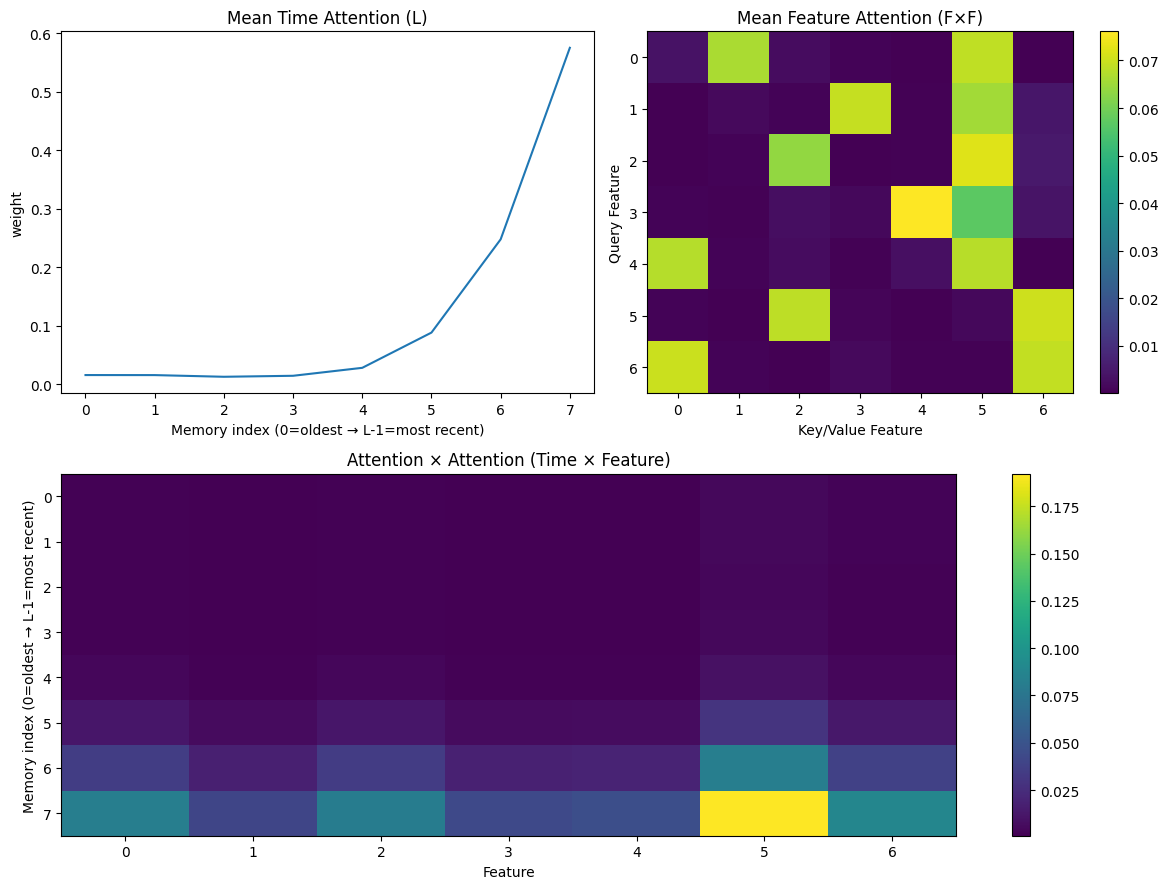

In [5]:
# visualize_axial_attention.py
import numpy as np
import torch
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

# ---- Config you fill in ----
MODEL_PATH = r"C:\initial_model\attention\MlpPolicy\attention_MlpPolicy"   # your saved model
L = 8                                  # memory window used in your wrapper
F = 7                                   # number of metrics/features
MAX_EPISODE_STEPS = 500                 # for distance-based PE (ok if larger than episode)

# observations_7: numpy array of shape (T, 7) collected from your test_model (or similar)
# e.g., load from .npy or .npz
observations_7 = np.load(r'C:\initial_model\attention\MlpPolicy\observations.npy')  # shape (T, 7), values in [0,1]
observations_7 = observations_7.squeeze(axis=1)
# ---- Helpers to rebuild Dict obs for the policy ----
def build_obs_dict_seq(seq_7, t, L, max_steps):
    """
    Build a single-sample Dict observation at time t from a flat sequence of (7,) obs.
    Returns a dict with N=1 batch: keys 'h', 'memories', 'mask', 'memory_indices', 'current_index'.
    """
    # current obs (7,)
    h = seq_7[t].astype(np.float32)

    # memory = last L previous h's (not including current), right-aligned
    mem = np.zeros((L, F), dtype=np.float32)
    mask = np.zeros((L,), dtype=np.int8)
    idx  = np.zeros((L,), dtype=np.int64)

    # valid past indices
    start = max(0, t - L)
    hist = seq_7[start:t]                        # up to (<= L, 7)
    n = hist.shape[0]
    if n > 0:
        mem[-n:] = hist.astype(np.float32)
        mask[-n:] = 1
        idx[-n:] = np.arange(start, t, dtype=np.int64)

    obs = {
        "h": h[None, :],                         # (1, 7)
        "memories": mem[None, :, :],             # (1, L, 7)  (raw memories; extractor will embed)
        "mask": mask[None, :],                   # (1, L)
        "memory_indices": idx[None, :],          # (1, L) absolute times
        "current_index": np.array([t], dtype=np.int64),   # (1,)
    }
    return obs

def get_attn_from_obs(model, obs_dict_np):
    """
    Runs the extractor forward to populate attention tensors.
    Returns (time_attn, feat_attn):
      - time_attn: (heads, L)  (averaged over query dim)
      - feat_attn: (heads, F, F)
    """
    policy = model.policy
    policy.eval()

    # Convert to torch tensors on correct device
    obs_t, _ = policy.obs_to_tensor(obs_dict_np)

    # Extract features (populates last attention)
    _ = policy.extract_features(obs_t)

    # Pull attention maps
    # time: (N, H, 1, L), feature: (N, H, F, F)
    t_attn = policy.features_extractor.last_time_attention
    f_attn = policy.features_extractor.last_feature_attention
    if t_attn is None or f_attn is None:
        raise RuntimeError("Attention maps not found. Ensure you are using the Axial extractor and called extract_features once.")

    # Remove batch and query dims
    t_attn = t_attn[0].squeeze(1).detach().cpu().numpy()   # (H, L)
    f_attn = f_attn[0].detach().cpu().numpy()              # (H, F, F)
    return t_attn, f_attn

# ---- Load model ----
device = "cuda" if torch.cuda.is_available() else "cpu"
model = PPO.load(MODEL_PATH, device=device)

# ---- Collect attentions over the sequence ----
T = observations_7.shape[0]
all_time = []  # list of (H, L)
all_feat = []  # list of (H, F, F)

for t in range(T):
    obs_dict = build_obs_dict_seq(observations_7, t, L=L, max_steps=MAX_EPISODE_STEPS)
    t_attn, f_attn = get_attn_from_obs(model, obs_dict)
    all_time.append(t_attn)
    all_feat.append(f_attn)

# Stack and average across time and heads
all_time = np.stack(all_time, axis=0)            # (T, H, L)
all_feat = np.stack(all_feat, axis=0)            # (T, H, F, F)

mean_time = all_time.mean(axis=(0, 1))           # (L,)
mean_feat = all_feat.mean(axis=(0, 1))           # (F, F)

# Normalize for display (optional, keeps ratios)
mean_time = mean_time / (mean_time.sum() + 1e-8)
mean_feat = mean_feat / (mean_feat.sum() + 1e-8)

# ---- Build "attention x attention" joint map ----
# A simple, interpretable choice:
#   - reduce feature attention to per-feature centrality (column mean)
#   - outer product with time attention -> (L, F)
feat_centrality = mean_feat.mean(axis=0)         # (F,) importance of each feature as a "recipient"
feat_centrality = feat_centrality / (feat_centrality.sum() + 1e-8)
joint_time_feat = np.outer(mean_time, feat_centrality)  # (L, F)

# If you prefer a richer joint tensor (L, F, F), use:
# joint_tensor = all_time.mean(axis=1)[:, :, None, None] * all_feat.mean(axis=1)  # (T, 1, L, 1, 1)*(T,H,F,F)->(T,H,L,F,F)
# joint_tensor = joint_tensor.mean(axis=(0,1))  # (L, F, F)
# ...and plot slices or norms over F.

# ---- Visualize ----
plt.figure(figsize=(12, 9))

# 1) Mean time attention
plt.subplot(2, 2, 1)
plt.title("Mean Time Attention (L)")
plt.plot(mean_time)
plt.xlabel("Memory index (0=oldest → L-1=most recent)")
plt.ylabel("weight")

# 2) Mean feature↔feature attention
plt.subplot(2, 2, 2)
plt.title("Mean Feature Attention (F×F)")
plt.imshow(mean_feat, aspect="auto")
plt.colorbar()
plt.xlabel("Key/Value Feature")
plt.ylabel("Query Feature")

# 3) Attention × Attention (L×F)
plt.subplot(2, 1, 2)
plt.title("Attention × Attention (Time × Feature)")
plt.imshow(joint_time_feat, aspect="auto")
plt.colorbar()
plt.xlabel("Feature")
plt.ylabel("Memory index (0=oldest → L-1=most recent)")

plt.tight_layout()
plt.show()


In [ ]:
imp = mean_feat.sum(axis=0)                    # incoming mass per feature (column-sum)
order = np.argsort(imp)[::-1]                 # sort high → low

plt.figure(figsize=(8, 4))
plt.title("Feature importance (from Mean Attention FxF)")
plt.bar(np.arange(len(imp)), imp[order])
plt.xticks(np.arange(len(imp)), [FEATURE_NAMES[i] for i in order], rotation=45, ha='right')       # show feature indices in sorted order
plt.ylabel("Importance (col-sum of attention)")
plt.tight_layout()
plt.show()

# Get policy training parameters

In [1]:
from stable_baselines3 import PPO

#model = PPO.load("path/to/model.zip", device="cpu")  # env not needed to inspect
model = PPO.load(r'C:\initial_model\historic\attention\MlpPolicy\attention_MlpPolicy')
# Core hyperparameters
cfg = {
    "algo": "PPO",
    "policy_class": type(model.policy).__name__,
    "n_steps": model.n_steps,
    "batch_size": model.batch_size,
    "n_epochs": model.n_epochs,
    "gamma": model.gamma,
    "gae_lambda": model.gae_lambda,
    "ent_coef": model.ent_coef,
    "vf_coef": model.vf_coef,
    "max_grad_norm": model.max_grad_norm,
    "target_kl": model.target_kl,
    # learning rate / clip can be constants or schedules:
    "learning_rate": (model.lr_schedule(1.0) if callable(model.lr_schedule) else model.learning_rate),
    "clip_range": (model.clip_range(1.0) if callable(model.clip_range) else model.clip_range),
    "clip_range_vf": (model.clip_range_vf(1.0) if callable(model.clip_range_vf) else model.clip_range_vf),
    # architecture & extractor config used to build the policy:
    "policy_kwargs": model.policy_kwargs,
    # bookkeeping:
    "num_timesteps_trained": model.num_timesteps,
    "sb3_version": getattr(model, "_sb3_version", "unknown"),
}

print(cfg)

# If you used a custom features extractor, you can see it too:
print("features_extractor:", type(model.policy.features_extractor).__name__)
print("fe_kwargs:", model.policy_kwargs.get("features_extractor_kwargs", {}))

# Observation/action spaces saved with the model (helpful for sanity):
print("obs_space:", model.observation_space)
print("act_space:", model.action_space)


{'algo': 'PPO', 'policy_class': 'MultiInputActorCriticPolicy', 'n_steps': 256, 'batch_size': 256, 'n_epochs': 20, 'gamma': 0.99, 'gae_lambda': 0.95, 'ent_coef': 0.02, 'vf_coef': 0.25, 'max_grad_norm': 0.5, 'target_kl': None, 'learning_rate': 0.0003, 'clip_range': 0.2, 'clip_range_vf': 0.2, 'policy_kwargs': {'features_extractor_class': <class 'attention_axial.AxialTransformerFeaturesExtractor'>, 'features_extractor_kwargs': {'config': {'num_blocks': 2, 'embed_dim': 128, 'num_heads': 4, 'positional_encoding': 'relative', 'feature_pool': 'mean'}, 'max_episode_steps': 500}, 'net_arch': [{'pi': [128, 128], 'vf': [128, 128]}]}, 'num_timesteps_trained': 600576, 'sb3_version': 'unknown'}
features_extractor: AxialTransformerFeaturesExtractor
fe_kwargs: {'config': {'num_blocks': 2, 'embed_dim': 128, 'num_heads': 4, 'positional_encoding': 'relative', 'feature_pool': 'mean'}, 'max_episode_steps': 500}
obs_space: Dict(current_index:Box(0, 499, (), int64), h:Box([0. 0. 0. 0. 0. 0. 0.], [1. 1. 1. 1. 

# gAWRL specific visualizations

In [15]:
from stable_baselines3 import PPO
model  = PPO.load(r'C:\initial_model\historic_3\gawrl_old_PPO_1\attention_MlpPolicy_mlp_gawrl_viz')
from attention_gawrl_viz import *
# Attention (either PPO or RecurrentPPO model)

c:\Users\ultramarine\Desktop\ppo_magisterka\trainloop_driver_official\trainloop_driver_final\trainloop-driver\attention_gawrl_viz.py:521: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


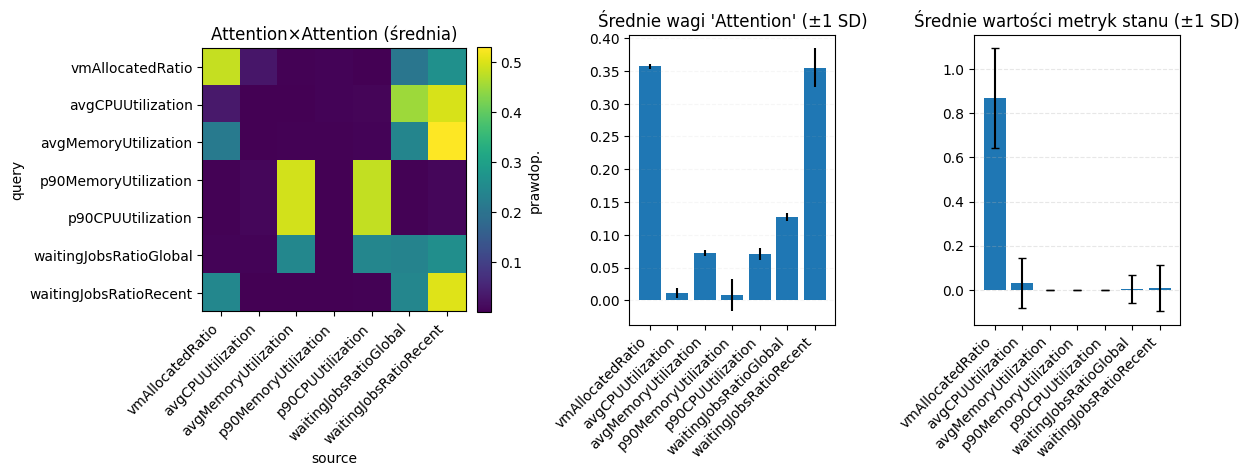

In [17]:
obs = np.load(r'C:\initial_model\historic_3\gawrl_old_PPO_1\observations_attention_MlpPolicy_1.npy')
fig = plot_attention_state_from_model(model, obs, feature_names=FEATURE_NAMES)
display(fig)